In [92]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils.utils import seed_everything, search_eps_for_rating
from models.model import BasicMF, RatingRecoverModel, ObservationModel
from utils.generate_data import load_movielens
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

## 一. 固定种子

In [93]:
seed_everything(42)

## 二. 读取数据

In [94]:
seed_everything(42)
ratings, num_users, num_items = load_movielens("data/u.data")
ratings = ratings.values
ratings, num_users, num_items

(array([[ 195,  241,    3],
        [ 185,  301,    3],
        [  21,  376,    1],
        ...,
        [ 275, 1089,    1],
        [  12,  224,    2],
        [  11,  202,    3]]),
 943,
 1682)

## 三. 生成ratings

### （一）寻找最优参数

In [95]:
seed_everything(42)
train, test = train_test_split(ratings, test_size=0.2, random_state=0)
train = DataLoader(torch.tensor(train), batch_size=2**12,shuffle=True)
test = DataLoader(torch.tensor(test), batch_size=2**12, shuffle=False)

In [96]:
K = 100
alpha = 1e-3
lr = 1e-3

100%|██████████| 5/5 [00:00<00:00, 84.02it/s]


0.9194790244102478

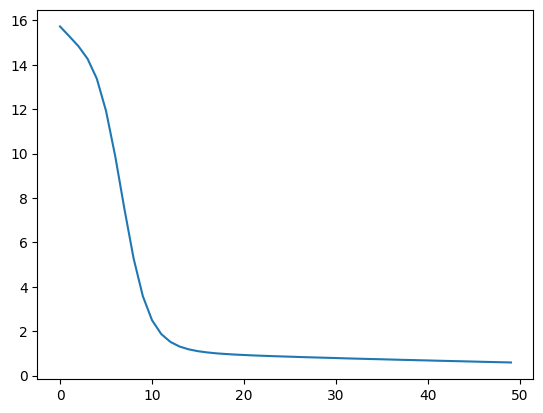

In [97]:
seed_everything(42)
rating_net = BasicMF(num_users, num_items, embedding_dim=K)
RatingModel = RatingRecoverModel(rating_net, train, test, device="cuda:0")
RatingModel.fit(epochs=50, lr=lr, alpha=alpha, weight_decay=1e-4)

### （二）使用最优参数训练

100%|██████████| 25/25 [00:00<00:00, 89.11it/s]


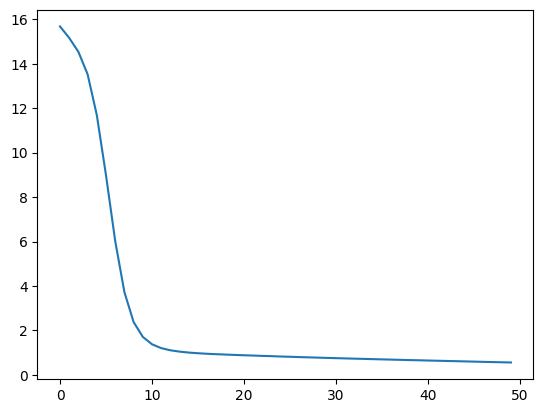

In [98]:
seed_everything(42)
train = DataLoader(torch.tensor(ratings), batch_size=2**12,shuffle=True)
rating_net = BasicMF(num_users, num_items, embedding_dim=K)
RatingModel = RatingRecoverModel(rating_net, train, None, device="cuda:0")
RatingModel.fit(epochs=50, lr=lr, alpha=alpha, weight_decay=1e-4)

In [99]:
r = RatingModel.get_rating()
r

tensor([[5.0000, 3.2957, 5.0000,  ..., 1.4069, 2.3686, 2.8275],
        [4.1397, 1.5415, 3.7220,  ..., 1.0000, 1.7927, 1.7987],
        [3.0915, 1.0000, 2.8606,  ..., 1.0000, 1.3218, 1.5241],
        ...,
        [5.0000, 3.0387, 5.0000,  ..., 1.5417, 2.2248, 2.6709],
        [3.8014, 1.5532, 3.5233,  ..., 1.0000, 1.6005, 1.6699],
        [4.9221, 2.8817, 5.0000,  ..., 1.1069, 1.8326, 2.4262]],
       device='cuda:0', grad_fn=<ClampBackward1>)

### （三）寻找eps并生成相关矩阵

In [100]:
eps = search_eps_for_rating(r)
eps

3.864297866821289

In [101]:
rel = torch.sigmoid(r-eps)
rel

tensor([[0.7569, 0.3616, 0.7569,  ..., 0.0789, 0.1831, 0.2618],
        [0.5684, 0.0893, 0.4645,  ..., 0.0539, 0.1119, 0.1125],
        [0.3159, 0.0539, 0.2682,  ..., 0.0539, 0.0729, 0.0878],
        ...,
        [0.7569, 0.3046, 0.7569,  ..., 0.0893, 0.1625, 0.2327],
        [0.4843, 0.0902, 0.4156,  ..., 0.0539, 0.0942, 0.1003],
        [0.7423, 0.2724, 0.7569,  ..., 0.0597, 0.1159, 0.1918]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)

(array([4.75209875, 2.08307812, 1.55912909, 1.21614714, 0.96925837,
        0.80300925, 0.66295048, 0.56005773, 0.4740189 , 1.14616228]),
 array([0.05394693, 0.1242412 , 0.19453548, 0.26482975, 0.33512402,
        0.40541828, 0.47571257, 0.5460068 , 0.61630112, 0.68659538,
        0.75688964]),
 <BarContainer object of 10 artists>)

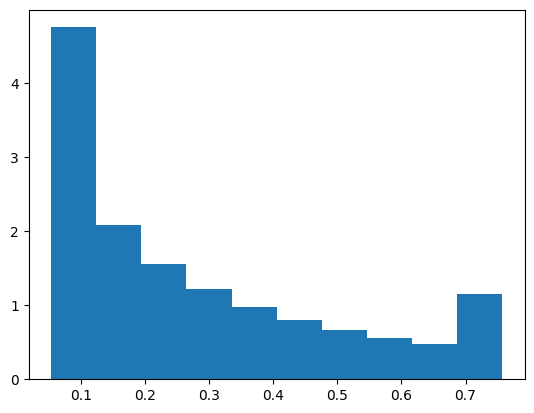

In [102]:
plt.hist(pd.DataFrame(rel.detach().cpu().numpy().reshape(-1)), density=True)

## 四. 生成theta

In [103]:
seed_everything(42)
all_data = pd.DataFrame(np.zeros((num_users, num_items))).stack().reset_index()
all_data = all_data.values[:, :2]
pos_data = ratings[:, :2]
unlabeled_data = np.array(list(set(map(tuple, all_data)) - set(map(tuple, pos_data))), dtype=int)
expo_data = np.r_[np.c_[pos_data, np.ones(pos_data.shape[0])], np.c_[unlabeled_data, np.zeros(unlabeled_data.shape[0])]]

### （一）寻找最优参数

In [104]:
seed_everything(42)
observed_data = expo_data[expo_data[:, 2]==1]
unobserved_data = expo_data[expo_data[:, 2]==0]
train_obs, test_obs = train_test_split(observed_data, test_size=0.2, random_state=0)
rate = len(test_obs)/len(unobserved_data)
train_unobs, test_unobs = train_test_split(unobserved_data, test_size=rate, random_state=0)
train = np.r_[train_obs, train_unobs]
test = np.r_[test_obs, test_unobs]
train = DataLoader(torch.tensor(train), batch_size=2**12,shuffle=True)
test = DataLoader(torch.tensor(test), batch_size=2**12, shuffle=False)

In [105]:
K = 100
alpha = 1e-4
lr = 1e-3

100%|██████████| 10/10 [00:00<00:00, 116.30it/s]


tensor(0.7140, device='cuda:0')

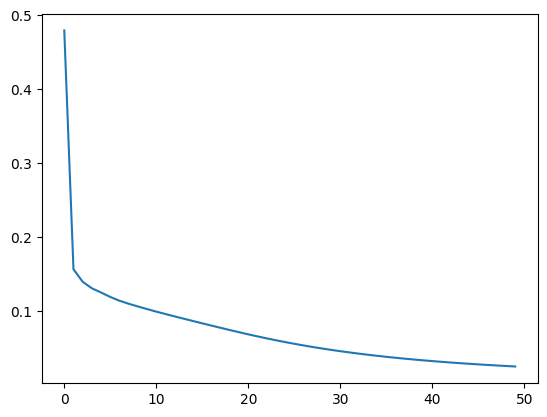

In [106]:
seed_everything(42)
observing_net = BasicMF(num_users, num_items, embedding_dim=K)
ObservingModel = ObservationModel(observing_net, train, test, device="cuda:0")
ObservingModel.fit(epochs=50, lr=lr, alpha=alpha, weight_decay=1e-4)

### （二）使用最优参数

100%|██████████| 388/388 [00:04<00:00, 78.00it/s]


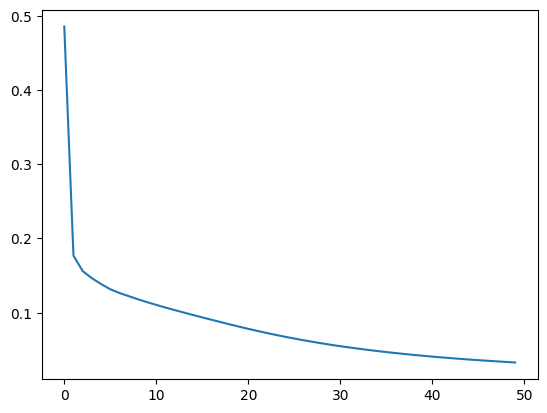

In [107]:
seed_everything(42)
train = DataLoader(torch.tensor(expo_data), batch_size=2**12,shuffle=True)
observing_net = BasicMF(num_users, num_items, embedding_dim=K)
ObservingModel = ObservationModel(observing_net, train, None, device="cuda:0")
ObservingModel.fit(epochs=50, lr=lr, alpha=alpha, weight_decay=1e-4)

In [108]:
theta =  ObservingModel.get_theta()
theta = torch.clip(theta, 1e-4, 1-1e-4)

### （三）调整并生成theta

In [109]:
theta = torch.sigmoid(torch.logit(theta)*0.3-2.5)
pd.DataFrame(theta.detach().cpu().numpy().reshape(-1)).describe()

,0
count,1.586126e+06
mean,3.282538e-02
std,6.879990e-02
min,5.152681e-03
25%,6.050491e-03
50%,1.169142e-02
75%,2.480029e-02
max,5.653791e-01


(array([15.96850457,  0.79640799,  0.31665908,  0.24107864,  0.17286939,
         0.11032088,  0.07232809,  0.04860511,  0.03425653,  0.08889367]),
 array([0.00515268, 0.06117533, 0.11719798, 0.17322062, 0.22924326,
        0.28526592, 0.34128857, 0.39731121, 0.45333385, 0.5093565 ,
        0.56537914]),
 <BarContainer object of 10 artists>)

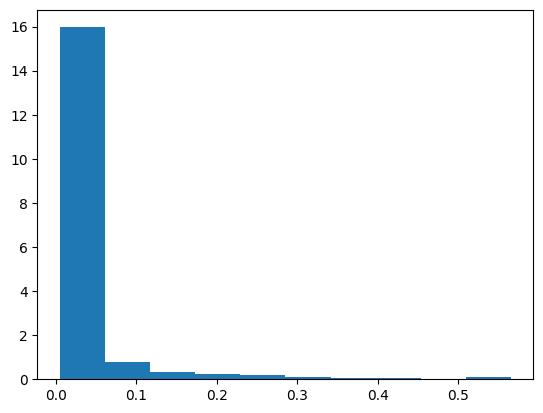

In [110]:
plt.hist(pd.DataFrame(theta.detach().cpu().numpy().reshape(-1)), density=True)

## 五. 保存

In [111]:
semi_data = np.c_[all_data, 
             pd.DataFrame(rel.cpu().detach().numpy()).stack().values, 
             pd.DataFrame(theta.cpu().detach().numpy()).stack().values]
print(semi_data)
pd.DataFrame(semi_data).to_csv("data/semi-data")

[[0.00000000e+00 0.00000000e+00 7.56889641e-01 5.33785701e-01]
 [0.00000000e+00 1.00000000e+00 3.61566901e-01 5.65379143e-01]
 [0.00000000e+00 2.00000000e+00 7.56889641e-01 3.59815896e-01]
 ...
 [9.42000000e+02 1.67900000e+03 5.96710257e-02 1.25410818e-02]
 [9.42000000e+02 1.68000000e+03 1.15910679e-01 2.78589241e-02]
 [9.42000000e+02 1.68100000e+03 1.91834003e-01 1.92112718e-02]]
